In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
import nltk
import tqdm


from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import trange, tqdm

In [7]:
tweets_df = pd.read_csv('C:\\Users\\Insti\\Desktop\\input\\health_tweets.csv') #.../input/health_tweets.csv


In [8]:
# create df of handle and tweet only to easily see how tweet is formatted
simple_df  = tweets_df[['username', 'tweet']]
simple_df.head() 

,username,tweet
0,bbchealth,How the UK’s coronavirus epidemic compares to ...
1,bbchealth,Health workers on frontline to be tested in En...
2,bbchealth,Coronavirus: Protective gear guidance 'to be u...
3,bbchealth,Coronavirus: What are ventilators and why are ...
4,bbchealth,Coronavirus: 'Act early to save more than 30 m...


## Tweets before cleaning

In [9]:
sample = simple_df.sample(n=10, random_state = 0) 

In [10]:
sample.style.set_properties(subset=['tweet'], **{'width': '500px'})

,username,tweet
8336,bbchealth,NI test results due over Ebola virus http://bbc.in/10Pccbm
65222,HarvardHealth,"Is the food pyramid still accurate? No, but the healthy eating plate is: http://hvrd.me/Kx1Lv pic.twitter.com/Bw8k9JGL89 via @HarvardAskDrK"
117965,NYTHealth,Early pregnancy loss is not uncommon. Many women miscarry before they know they’re pregnant. https://nyti.ms/2HFUOwZ
78508,KHNews,"Emergency Rooms Are Front Line For Enrolling New Obamacare Customers, @SarahVarney reports: http://khne.ws/1d0ITnX"
2347,bbchealth,"Organ donation campaigner, 18, in New Year Honours http://bbc.in/2DyFCyh"
86113,NBCNewsHealth,Juul to ban most of its flavored products from retail stores https://nbcnews.to/2DkcDBa
60718,HarvardHealth,"The more meat you eat, the higher your risk of diabetes, heart disease, and stroke is. #HarvardHealth #nutrition http://bit.ly/2Roxac2 pic.twitter.com/Rs6ovTnV9J"
28377,foxnewshealth,The report calls for screening of all children by the time the turn 1 and again between ages 2 and 3 http://fxn.ws/2fksilh
164951,Reuters_Health,Halozyme shares jump after FDA lifts hold on trial http://reut.rs/1nl9RM6
147470,Reuters_Health,Elite athletes not at higher risk of birth complications https://reut.rs/2CSLdmJ


In [11]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retween and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

### Using Stemming for data cleaning

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Insti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stopwords = nltk.corpus.stopwords.words('english')
# word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'         # define a string of punctuation symbols

# main function to clean tweet
def clean_tweet(tweet, bigrams=False):  # master function to clean tweet
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in stopwords] # remove stopwords
#     tweet_token_list = [word_rooter(word) if '#' not in word else word
#                         for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [14]:
simple_clean_df_stem = simple_df.tweet.apply(clean_tweet).to_frame()

#### Tweets after cleaning (stemming)

In [15]:
sample_clean_stem = simple_clean_df_stem.sample(n=10, random_state=0)

In [16]:
sample_clean_stem.style.set_properties(subset=['tweet'], **{'width': '500px'})

,tweet
8336,ni test results due ebola virus
65222,food pyramid still accurate healthy eating plate via
117965,early pregnancy loss uncommon many women miscarry know they’re pregnant
78508,emergency rooms front line enrolling new obamacare customers reports
2347,organ donation campaigner new year honours
86113,juul ban flavored products retail stores
60718,meat eat higher risk diabetes heart disease stroke #harvardhealth #nutrition
28377,report calls screening children time turn ages
164951,halozyme shares jump fda lifts hold trial
147470,elite athletes higher risk birth complications


### Using Lemmatization for data cleaning

In [17]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Insti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
import gensim
stopwords = nltk.corpus.stopwords.words('english')
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'         # define a string of punctuation symbols

## functions leveraged from https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925

def lemmatize_stemming(tweet):
    return WordNetLemmatizer().lemmatize(tweet, pos='v')

# tokenize and lemmatize
def lemmatize(tweet):
    result=[]
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:   # drops words with 3 or less characters
            result.append(lemmatize_stemming(token))
    return result

def clean_tweet(tweet, bigrams=False):   # master function to clean tweet
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    
    tweet_token_list = lemmatize(tweet)  # apply lemmatization and tokenization

    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [19]:
simple_clean_df_lemma = simple_df.tweet.apply(clean_tweet).to_frame()  

#### Tweets after cleaning (lemmatization)

In [20]:
sample_clean_lemma = simple_clean_df_lemma.sample(n=10, random_state=0)

In [21]:
sample_clean_lemma.style.set_properties(subset=['tweet'], **{'width': '500px'})

,tweet
8336,test result ebola virus
65222,food pyramid accurate healthy eat plate
117965,early pregnancy loss uncommon women miscarry know pregnant
78508,emergency room line enrol obamacare customers report
2347,organ donation campaigner year honour
86113,juul flavor products retail store
60718,meat higher risk diabetes heart disease stroke harvardhealth nutrition
28377,report call screen children time turn age
164951,halozyme share jump lift hold trial
147470,elite athletes higher risk birth complications


In [22]:
# ## alternate approach to cleaning tweet data
# ## taken from https://towardsdatascience.com/topic-modeling-of-2019-hr-tech-conference-twitter-d16cf75895b6

# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import stopwords, wordnet
# import nltk

# def get_wordnet_pos(word):
#     """
#     Map POS tag to first character lemmatize() accepts
#     """
#     tag = nltk.pos_tag([word])[0][1][0].upper()
#     tag_dict = {"J": wordnet.ADJ,
#                 "N": wordnet.NOUN,
#                 "V": wordnet.VERB,
#                 "R": wordnet.ADV}

#     return tag_dict.get(tag, wordnet.NOUN)

# text_clean = text.lower()
# # Remove non-alphabet
# text_clean = re.sub(r'[^a-zA-Z]|(\w+:\/\/\S+)',' ', text_clean).split()    
# # Remove short words (length < 3)
# text_clean = [w for w in text_clean if len(w)>2]
# # Lemmatize text with the appropriate POS tag
# lemmatizer = WordNetLemmatizer()
# text_clean = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text_clean]
# # Filter out stop words in English 
# stops = set(stopwords.words('english')).union(additional_stop_words)
# text_clean = [w for w in text_clean if w not in stops]

### EDA for counts of Bigrams

In [23]:
def find_bigrams(tweet, bigrams=True):   # master function to clean tweet
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    
    tweet_token_list = lemmatize(tweet)  # apply lemmatization and tokenization

    if bigrams:
        tweet_token_list = [tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    #tweet_token_list + (taken from above assignment)
    tweet_token_list= ' '.join(tweet_token_list)
    return tweet_token_list

In [24]:
bigrams = simple_df.tweet.apply(find_bigrams).to_frame()

In [25]:
#check bigram example
print((bigrams.iloc[0,0]))

coronavirus_epidemic epidemic_compare compare_countries


In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=500, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(bigrams['tweet']).toarray()

# tf_feature_names tells us what word each column in the matric represents
bigram_names = vectorizer.get_feature_names()


In [27]:
#Convert tf to a dataframe, assign columns to bigram names, and calculate total
tf = pd.DataFrame(tf)
tf.columns = [bigram_names]
sample_tf = tf.head()
tf.loc['total',:] = tf.sum(axis=0)
tf.loc['total']

blood_pressure       664.0
breast_cancer       1308.0
cancer_drug          720.0
drug_price           609.0
health_care         2761.0
health_insurance     752.0
health_officials     544.0
heart_attack         680.0
heart_disease        738.0
long_term            522.0
mental_health       1759.0
need_know            756.0
nurse_home           526.0
public_health        667.0
study_find          1471.0
study_say           1349.0
study_suggest        552.0
unite_state          525.0
weight_loss          711.0
zika_virus           598.0
Name: total, dtype: float64

Text(0, 0.5, 'Bigrams')

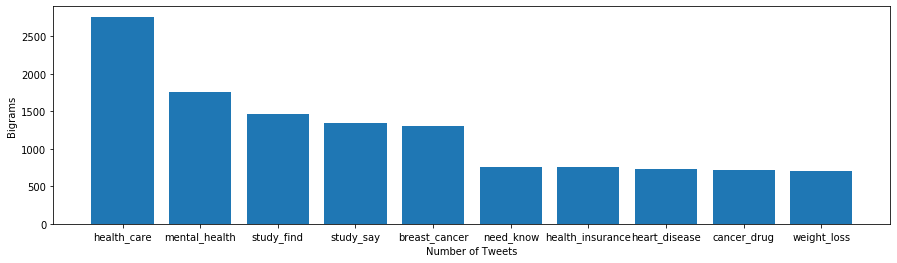

In [28]:
topicslist = pd.DataFrame(data = tf.loc['total'])
topicslist = topicslist.reset_index()
topicslist = topicslist.rename(columns = {"level_0":"bigrams"})
topicslist = topicslist.sort_values(by = ['total'], ascending = False)
topicslist_10 = topicslist[:10]

topicslist_10['bigrams']
fig = plt.figure()
fig.set_figwidth(15)
plt.bar(topicslist_10['bigrams'], topicslist_10['total'])
plt.xlabel('Number of Tweets')
plt.ylabel('Bigrams')
